Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - loss: 0.3536 - val_loss: 0.1396
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 311s 1s/step - loss: 0.1268 - val_loss: 0.1055
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 326s 1s/step - loss: 0.1029 - val_loss: 0.0947
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - loss: 0.0944 - val_loss: 0.0901
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - loss: 0.0905 - val_loss: 0.0882
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - loss: 0.0884 - val_loss: 0.0864
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - loss: 0.0865 - val_loss: 0.0866
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 310s 1s/step - loss: 0.0855 - val_loss: 0.0844
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - loss: 0.0845 - val_loss: 0.0835
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - loss: 0.0837 - val_loss: 0.0830
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - loss: 0.0826 - val_loss: 0.0819
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 

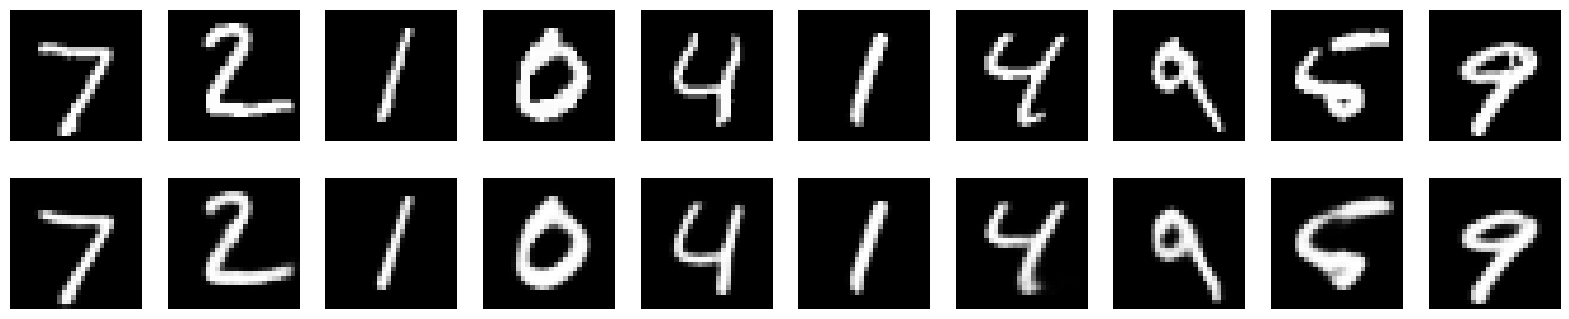

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

# Dimensión de la entrada (MNIST: imágenes 28x28 en escala de grises)
input_shape = (28, 28, 1)

# Construcción del Encoder
def build_encoder():
    encoder = models.Sequential()
    encoder.add(layers.Input(shape=input_shape))
    encoder.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    encoder.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    encoder.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(layers.MaxPooling2D((2, 2), padding='same'))
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(64, activation='relu'))  # Representación comprimida
    return encoder

# Construcción del Decoder
def build_decoder():
    decoder = models.Sequential()
    decoder.add(layers.Input(shape=(64,)))  # Recibe el código comprimido
    decoder.add(layers.Dense(4 * 4 * 128, activation='relu'))
    decoder.add(layers.Reshape((4, 4, 128)))  # Reconstrucción de la imagen comprimida
    decoder.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(layers.Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation='relu'))
    decoder.add(layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid'))  # Salida reconstruida (28x28x1)

    # Aseguramos que la salida tenga tamaño (28, 28, 1)
    decoder.add(layers.Cropping2D(((2, 2), (2, 2))))  # Recortar de (32, 32, 1) a (28, 28, 1)
    return decoder

# Construcción del modelo Autoencoder (Encoder + Decoder)
def build_autoencoder(encoder, decoder):
    input_img = layers.Input(shape=input_shape)
    encoded = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder = models.Model(inputs=input_img, outputs=decoded)
    return autoencoder

# Compilación del modelo Autoencoder
encoder = build_encoder()
decoder = build_decoder()
autoencoder = build_autoencoder(encoder, decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# Cargar y preprocesar el conjunto de datos MNIST
(X_train, _), (X_test, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype('float32') / 255.0  # Normalizar a [0,1]
X_test = X_test.astype('float32') / 255.0    # Normalizar a [0,1]
X_train = np.expand_dims(X_train, axis=-1)   # Expandir dimensión para canales (28, 28, 1)
X_test = np.expand_dims(X_test, axis=-1)

# Entrenamiento del Autoencoder
autoencoder.fit(X_train, X_train, epochs=20, batch_size=256, shuffle=True, validation_data=(X_test, X_test))

# Función para mostrar imágenes originales y reconstruidas
def plot_reconstructed_images(original, reconstructed, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Imágenes originales
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap="gray")
        plt.axis("off")

        # Imágenes reconstruidas
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap="gray")
        plt.axis("off")
    plt.show()

# Reconstrucción de imágenes del conjunto de prueba
reconstructed_imgs = autoencoder.predict(X_test[:10])
plot_reconstructed_images(X_test[:10], reconstructed_imgs)


### Explicación del código:
Claro, te explicaré en detalle cada parte del código que genera un **Autoencoder** para el conjunto de datos MNIST, y cómo funciona cada componente del modelo y su estructura.

### 1. **Definición de la arquitectura: Encoder y Decoder**

#### 1.1. **Encoder**

- **Entrada**: La entrada es una imagen de tamaño `(28, 28, 1)` (imagen de MNIST en escala de grises).
- **Convolución y Pooling**: Se aplican varias capas de convolución (`Conv2D`) seguidas de capas de reducción de tamaño (`MaxPooling2D`). Cada vez que aplicamos `MaxPooling2D`, la resolución de la imagen se reduce a la mitad, mientras que el número de filtros aumenta, capturando más características complejas.
    - Después de la primera capa de `MaxPooling2D`, la imagen pasa de `(28, 28, 32)` a `(14, 14, 32)`.
    - Luego, después de la segunda, de `(14, 14, 64)` a `(7, 7, 64)`.
    - Finalmente, termina con una resolución de `(4, 4, 128)`.
- **Aplanado (`Flatten`)**: Se convierte el tensor 3D (imagen comprimida) en un vector 1D de tamaño `4*4*128` (2048 dimensiones).
- **Representación comprimida**: Este vector es mapeado a un espacio latente de menor dimensionalidad (64 dimensiones). Este es el "código" o "representación comprimida" que el **encoder** genera para la imagen original.

#### 1.2. **Decoder**

- **Entrada**: El **decoder** toma la representación comprimida de tamaño 64 generada por el **encoder**.
- **Expansión de dimensiones**:
    - Primero, el vector 1D de 64 dimensiones se expande de nuevo a un tensor 3D de tamaño `(4, 4, 128)` usando `Dense` y `Reshape`.
    - Luego, se utilizan capas de `Conv2DTranspose` para "deshacer" el efecto de las capas de convolución y pooling en el **encoder**. Estas capas realizan un proceso inverso, aumentando gradualmente la resolución de la imagen.
    - La imagen pasa por diferentes resoluciones: `(4, 4, 128)` → `(8, 8, 128)` → `(16, 16, 64)` → `(32, 32, 32)`.
- **Salida corregida**: Al final, se utiliza una capa de `Conv2D` para obtener una imagen de una sola capa (es decir, una imagen en escala de grises con forma `(32, 32, 1)`). Para ajustar el tamaño final a `(28, 28, 1)`, se aplica una capa de `Cropping2D` que recorta la imagen de `(32, 32)` a `(28, 28)`.

### 2. **Ensamblado del Autoencoder**

Aquí estamos combinando el **encoder** y el **decoder** en un solo modelo completo, llamado **Autoencoder**. El modelo toma como entrada la imagen original, la comprime en una representación latente usando el **encoder**, y luego intenta reconstruir la imagen original usando el **decoder**.

### 3. **Entrenamiento del Autoencoder**

- **Compilación**: El modelo se compila utilizando el optimizador `adam` y la función de pérdida `binary_crossentropy`. Esta función de pérdida es adecuada ya que los valores de los píxeles de la imagen están normalizados entre 0 y 1, lo que hace que sea comparable a una clasificación binaria.
  
### 4. **Preprocesamiento de datos**


- **Carga de datos**: Se carga el conjunto de datos MNIST que contiene imágenes de dígitos manuscritos (60,000 para entrenamiento y 10,000 para prueba).
- **Normalización**: Se normalizan los valores de los píxeles dividiéndolos entre 255, de modo que estén en el rango `[0, 1]`.
- **Expansión de dimensiones**: Se expande la forma de los datos de `(28, 28)` a `(28, 28, 1)` para agregar un canal de color (necesario para las capas convolucionales).

### 5. **Entrenamiento**


- El autoencoder es entrenado durante 20 épocas usando un tamaño de lote de 256.
- La imagen original se usa tanto como entrada como como etiqueta para la salida (ya que el objetivo es reconstruir la imagen).

### 6. **Visualización de resultados**



Esta parte toma 10 imágenes de prueba del conjunto de datos MNIST y las pasa por el autoencoder para obtener las imágenes reconstruidas. Luego se muestran lado a lado las imágenes originales y
